In [40]:
#from mypy.datautil import download_data_from_mysqldb
#from mypy.stats import within_normalized_CI
#import json
#import statsmodels.formula.api as sm
#from scipy.stats import pearsonr

import json
import numpy as np
import sys
sys.path.append('../../')
from util import *
from viz import tableau20
from biasedHypGen_experiment2 import *


# figure settings
AX_LW = 0.5
AX_COL = (.8, .8, .8)
cc_col = [tableau20[6], tableau20[0]]


COND_LABELS = ['1D-REL', '1D-ABS', '2D-REL', '2D-ABS']
rt = ['1D', '1D', '2D', '2D']
st = ['relative', 'absolute', 'relative', 'absolute']
rr = [['1D-F', '1D-C'], ['1D-F', '1D-C'], ['2D-P', '2D-N'], ['2D-P', '2D-N']]

def lab(cond, cc):
    
    if cond == 0:
        return ['fertilizer', 'chemical'][cc]
    elif cond == 1:
        return ['fertilizer', 'chemical'][cc]
    elif cond == 2:
        return ['positive', 'negative'][cc]
    elif cond == 3:
        return ['positive', 'negative'][cc]

    
FIGDEST = '../../results_figures/experiment2'
DATADEST = '../../data_proc/experiment2'

In [41]:
SUBJ = [234, 236, 238, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, \
        253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, \
        268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, \
        284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, \
        298, 299, 300, 301, 302, 303, 305, 306, 307, 308, 309, 310, 311, 312, \
        313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 325, 328, 329, \
        330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 342, 343, 344, 345, \
        346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 362, 363, \
        364, 365, 366, 367, 373, 374, 376, 377]

In [20]:
questiondata = pd.read_csv('%s/questiondata.csv' % DATADEST, index_col=0)
conds = [condition(sid) for sid in SUBJ]

print 'Total N:', len(SUBJ)
for c in range(4):
    print 'N(%s): %s' % (COND_LABELS[c], conds.count(c))
    
print '\nAge\n' + '-'*20
print questiondata[questiondata.age!=-1].age.describe()[['mean', 'std']]

print '\nGender\n' + '-'*20
print questiondata['gender'].value_counts()

Total N: 120
N(1D-REL): 30
N(1D-ABS): 30
N(2D-REL): 30
N(2D-ABS): 30

Age
--------------------
mean    25.230769
std      3.361508
Name: age, dtype: float64

Gender
--------------------
female    62
male      54
noresp     1
Name: gender, dtype: int64


In [7]:
# Data by block
arr = []
for sid in SUBJ:
    acc = accuracy(sid)
    nsel = n_selection_changes_either_dim(sid)    
    dist_mn = sample_distance_by_block(sid).mean(axis=1)
    dist_med = np.array([np.median(b) for b in sample_distance_by_block(sid)])
    avg_dist_med = np.mean(dist_med) * np.ones(8)

    for block in range(8):
        arr.append([sid, condition(sid), stim_condition(sid), rule_condition(sid), rule_counter(sid) % 2,
                    rule_direction(sid), rule_relation(sid), block, 
                    acc[block], dist_mn[block], dist_med[block], avg_dist_med[block], nsel[block]])
        
blockdf = pd.DataFrame(arr, columns=['sid', 'cond', 'dimtype', 'ruletype', 'counter', 'ruledir', 'rulerelation', 
                                     'block', 'acc', 'dist_mn', 'dist_med', 'avg_dist_med', 'nsel'])

mn_nsel = blockdf.groupby('sid').apply(lambda d: np.mean(d.nsel) * np.ones(8)).values
arr = []
for x in mn_nsel:
    for val in x:
        arr.append(val)
blockdf['mn_nsel'] = arr

mn_nsel_early = blockdf.groupby('sid').apply(lambda d: np.mean(d[d.block < 4].nsel) * np.ones(8)).values
arr = []
for x in mn_nsel_early:
    for val in x:
        arr.append(val)
blockdf['mn_nsel_early'] = arr

mn_nsel_late = blockdf.groupby('sid').apply(lambda d: np.mean(d[d.block >= 4].nsel) * np.ones(8)).values
arr = []
for x in mn_nsel_late:
    for val in x:
        arr.append(val)
blockdf['mn_nsel_late'] = arr

blockdf.to_csv('%s/data_by_block.csv' % DATADEST)

In [8]:
# Data aggregated across blocks
aggdf = blockdf.groupby('sid').agg(np.mean).reset_index()
aggdf['dimtype'] = aggdf['sid'].apply(lambda sid: stim_condition(sid))
aggdf['ruletype'] = aggdf['sid'].apply(lambda sid: rule_condition(sid))
aggdf['ruledir'] = aggdf['sid'].apply(lambda sid: rule_direction(sid))
aggdf['rulerelation'] = aggdf['sid'].apply(lambda sid: rule_relation(sid))
aggdf.drop('block', 1, inplace=True)
aggdf.to_csv('%s/data_agg.csv' % DATADEST)

# Load data if already created

In [42]:
blockdf = pd.read_csv('%s/data_by_block.csv' % DATADEST)
aggdf = pd.read_csv('%s/data_agg.csv' % DATADEST)

# Classification accuracy

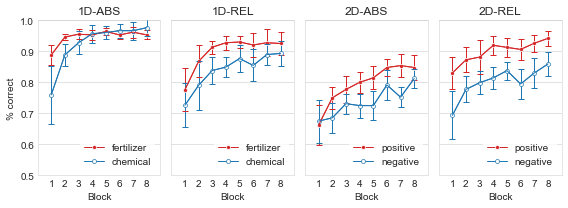

In [44]:
cc_styl = ['-', '-']
cc_styl = ['-o', '-o']
ms = 4

fig, ax = plt.subplots(1, 4, figsize=(8,3), sharey=True)

for i, c in enumerate([1, 0, 3, 2]):
    axi = ax[i]

    for cc in [0, 1]:
    
        conddf = blockdf[(blockdf.ruletype==rt[c]) & (blockdf.dimtype==st[c]) & (blockdf.rulerelation==rr[c][cc])]
        m = conddf.groupby('block').apply(lambda d: np.mean(d.acc))        
        CI = within_normalized_CI(conddf, 'block', 'acc', 'sid')['95-CI(within)'].values

        (_, caps, _) = axi.errorbar(np.arange(1, 9), m.values, yerr=CI, capsize=3,
                                    fmt='-', color=cc_col[cc], linewidth=1)
        for cap in caps:
            cap.set_color(cc_col[cc])
            cap.set_markeredgewidth(1)

        if cc==0:
            axi.plot(np.arange(1, 9), m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c, cc), markerfacecolor=cc_col[cc],
                     markeredgewidth=.7, markersize=ms, markeredgecolor='white', linewidth=1)
        else:
            axi.plot(np.arange(1, 9), m.values, cc_styl[cc], color=cc_col[cc],
                     label=lab(c,cc), markerfacecolor='white',
                     markeredgewidth=.7, markersize=ms, markeredgecolor=cc_col[cc], linewidth=1)

    
    axi.set_title(COND_LABELS[c])
    axi.set_ylim(0.5, 1)
    axi.set_xlim(0, 9)
    axi.set_xlabel('Block')
    leg = axi.legend(loc='lower right', frameon=True)
    leg.get_frame().set_linewidth(0.0)
    axi.set_xticks(range(1, 9))
    axi.yaxis.grid(alpha=.7)
    
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)

ax[0].set_ylabel('% correct')
plt.tight_layout()
plt.show()

fig.savefig('%s/exp2_accuracy.pdf' % FIGDEST, bbox_inches='tight')

# Selection distance from boundary

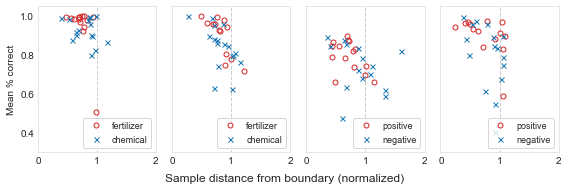

In [14]:
cc_col = [tableau20[6], tableau20[0]]

fig, ax = plt.subplots(1, 4, figsize=(8, 2.5), sharey=True)

for i, c in enumerate([1, 0, 3, 2]):
    axi = ax[i]
    #ref = [MED_SAMPLE_DIST_1D, MED_SAMPLE_DIST_2D][c/2]
    ref = 1
    axi.plot([ref, ref], [0, 1.1], '--', color='gray', alpha=.4, linewidth=1)
    
    for cc in [0, 1]:
    
        sel = blockdf[(blockdf.ruletype==rt[c]) & (blockdf.dimtype==st[c]) & (blockdf.rulerelation==rr[c][cc])]
        pts = sel.groupby('sid').apply(lambda d: d[['dist_med', 'acc']].mean()).values

        mark = 'o' if cc==0 else 'x'
        
        axi.plot(pts[:,0], pts[:,1], mark, 
                 markeredgecolor=cc_col[cc], markerfacecolor='None', markeredgewidth=1., markersize=5,
                 label=lab(c, cc))
    axi.set_xlim(0, 2)
    axi.set_xticks([0.01, 1, 2])
    axi.set_xticklabels([0, 1, 2])
    axi.set_ylim(0.3, 1.05)
    axi.legend(loc='lower right', frameon=True, prop={'size':9})  
    
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)


ax[0].set_ylabel('Mean % correct')

fig.text(0.5, -.03, 'Sample distance from boundary (normalized)', ha='center', fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('%s/exp2_sampledistance_x_accuracy.pdf' % FIGDEST, bbox_inches='tight')

# Modeling classification boundaries

In [17]:
# save classification data to csv
for sid in SUBJ:
    for block in range(8):
        tdf = pd.DataFrame(testdata(sid, block), columns=['x1', 'x2', 'resp', 'correct'])
        tdf['resp'] = map(lambda r: 0. if r=='success' else 1., tdf['resp'].values)
        tdf.to_csv('%s/testdata/testdata_%s_%s.csv' % (DATADEST, sid, block))

In [23]:
# load results
arr = []
for sid in SUBJ:
    for block in range(8):
        fitresult = pd.read_csv('%s/fit_boundaries/fit_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        fitresultx1 = pd.read_csv('%s/fit_boundaries/fitx1_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        fitresultx2 = pd.read_csv('%s/fit_boundaries/fitx2_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        
        arr.append([sid, condition(sid), rule_counter(sid), block, 
                    fitresult.loc['(Intercept)']['Estimate'],
                    fitresult.loc['x1']['Estimate'],
                    fitresult.loc['x2']['Estimate'],
                    fitresultx1.loc['(Intercept)']['Estimate'],
                    fitresultx1.loc['x1']['Estimate'],
                    1e-4,
                    fitresultx2.loc['(Intercept)']['Estimate'],
                    1e-4,
                    fitresultx2.loc['x2']['Estimate']])
fitdf = pd.DataFrame(arr, columns=['sid', 'cond', 'counter', 'block', 
                                   'c_int', 'c_x1', 'c_x2',
                                   'f1_c_int', 'f1_c_x1', 'f1_c_x2',
                                   'f2_c_int', 'f2_c_x1', 'f2_c_x2',
                                   ])
fitdf['intercept'] = -fitdf.c_int/fitdf.c_x2
fitdf['slope'] = -fitdf.c_x1/fitdf.c_x2

fitdf['x1_intercept'] = -fitdf.f1_c_int/fitdf.f1_c_x2
fitdf['x1_slope'] = -fitdf.f1_c_x1/fitdf.f1_c_x2

fitdf['x2_intercept'] = -fitdf.f2_c_int/fitdf.f2_c_x2
fitdf['x2_slope'] = 0

fitdf['2drule'] = 1 * ((np.abs(fitdf.slope) > .25) & (np.abs(fitdf.slope) < 4))
#fitdf['2drule_pos'] = 1 * ((fitdf.slope > .25) & (fitdf.slope < 4))
#fitdf['2drule_neg'] = 1 * ((fitdf.slope < -.25) & (fitdf.slope > -4))
fitdf['2drule_pos'] = 1 * (fitdf.slope > 0)
fitdf['2drule_neg'] = 1 * (fitdf.slope < 0)

In [24]:
# load results for comparison to null model
arr = []
for sid in SUBJ:
    for block in range(8):
        comp_result = pd.read_csv('%s/fit_boundaries/fit_comp_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        try:
            arr.append([comp_result.loc[1,'x'], comp_result.loc[2,'x'], comp_result.loc[3,'x'], comp_result.loc[4,'x']])
        except:
            print sid
            print comp_result
arr = np.array(arr)

fitdf['aic'] = arr[:,0]
fitdf['aic_x1'] = arr[:,1]
fitdf['aic_x2'] = arr[:,2]
fitdf['aic_null'] = arr[:,3]
fitdf['2drule_aic'] = 1*(fitdf['aic'] < fitdf['aic_x1']) & (fitdf['aic'] < fitdf['aic_x2']) & (fitdf['aic'] < fitdf['aic_null'])
fitdf['2drule_pos_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope > 0)
fitdf['2drule_neg_aic'] = 1*fitdf['2drule_aic']*(fitdf.slope < 0)

In [25]:
failed = fitdf[(fitdf['aic_null'] < fitdf['aic']) & 
               (fitdf['aic_null'] < fitdf['aic_x1']) & 
               (fitdf['aic_null'] < fitdf['aic_x2'])].shape[0]
print 'baseline was better for: %s (%s)' % (failed, failed/float(fitdf.shape[0]))

baseline was better for: 43 (0.0447916666667)


In [31]:
propdf = fitdf.groupby('sid').agg(np.mean).reset_index()[['sid', 'cond', 'counter', '2drule', '2drule_aic']]
st = []
rt = []
rv = []
for i, row in propdf.iterrows():

    st_i, rt_i, rv_i = aggdf.loc[aggdf.sid==int(row['sid'])][['dimtype', 'ruletype', 'rulerelation']].values[0]
    st.append(st_i)
    rt.append(rt_i)
    rv.append(rv_i)

propdf['dimtype'] = st
propdf['ruletype'] = rt
propdf['rulerelation'] = rv

propdf.to_csv('%s/prop2d.csv' % DATADEST)

In [26]:
p2d = {}
for cond in range(4):
    for cc in [0, 1]:
        p2d[(cond, cc)] = [fitdf[(fitdf.cond==cond) & (fitdf.block==block) & (fitdf.counter%2==cc)]['2drule_aic'].mean() \
                           for block in range(8)]

In [27]:
arr = []
for i, row in fitdf.iterrows():
     arr.append(rule_relation(row['sid']))
fitdf['variant'] = np.array(arr)

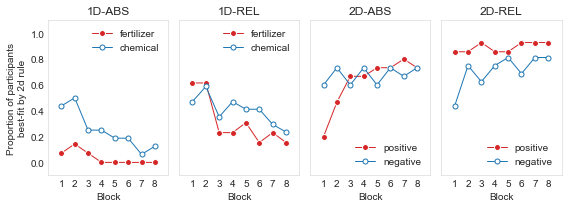

In [29]:
cc_styl = ['-o', '-o']
ms = 5

leg_loc = ['upper right', 'upper right', 'lower right', 'lower right']

fig, ax = plt.subplots(1, 4, figsize=(8, 3), sharey=True)
for i, cond in enumerate([1, 0, 3, 2]):
    axi = ax[i]

    sset = filter(lambda sid: condition(sid)==cond, SUBJ)
    
    for cc in [0, 1]:
        
        if cond < 2:
            rel = ['1D-F', '1D-C']
            lab = ['fertilizer', 'chemical']
        else:
            rel = ['2D-P', '2D-N']
            lab = ['positive', 'negative']
        sset_cc = filter(lambda sid: rule_relation(sid)==rel[cc], sset)
        lab_cc = lab[cc]
        sel = fitdf[fitdf.sid.apply(lambda s: s in sset_cc)]
                 
        pr = [sel[sel.block==block]['2drule_aic'].mean() for block in range(8)]
        if cc==0:
            axi.plot(range(1, 9), pr, cc_styl[cc], label=lab_cc, 
                     color=cc_col[cc], linewidth=1, markerfacecolor=cc_col[cc],
                     markeredgewidth=1, markersize=ms+1, markeredgecolor='white')
        else:
            axi.plot(range(1, 9), pr, cc_styl[cc], label=lab_cc, 
                     color=cc_col[cc], linewidth=1, markerfacecolor='white', markeredgecolor=cc_col[cc],
                     markeredgewidth=1, markersize=ms)


    axi.set_ylim(-.1, 1.1)
    axi.set_xlim(0, 9)
    axi.legend(loc=leg_loc[i])
    axi.set_xticks(range(1, 9))
    axi.set_xlabel('Block')
    axi.set_title(COND_LABELS[cond])
    for i in axi.spines.itervalues():
        i.set_linewidth(AX_LW)
        i.set_color(AX_COL)

ax[0].set_ylabel('Proportion of participants\nbest-fit by 2d rule')
plt.tight_layout()
plt.show()
fig.savefig('%s/exp2_prop_2d_rules.pdf' % FIGDEST, bbox_inches='tight')

In [91]:
def orthogonal_distance(pt, f1, f2):
    x0, y0 = pt
    x1, y1 = f1
    x2, y2 = f2
    return np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

arr = []
for i, row in fitdf.iterrows():
    
    sid = row['sid']
    
    best = np.argmin(row[['aic', 'aic_x1', 'aic_x2', 'aic_null']].values)
    if best == 0:
        intercept = row.intercept
        slope = row.slope
    elif best == 1:
        intercept = row.x1_intercept
        slope = row.x1_slope
    elif best == 2:
        intercept = row.x2_intercept
        slope = row.x2_slope
    
    cp = centerpoint(rule_condition(sid), 
                     rule_counter(sid), 
                     rule_offset(sid))
    
    arr.append(orthogonal_distance(cp, [0, intercept], [1, intercept + slope]))
fitdf['deviation'] = np.array(arr)

In [49]:
p2d_pos = {}
p2d_neg = {}
for cond in range(4):
    for cc in [0, 1]:
        p2d_pos[(cond, cc)] = [fitdf[(fitdf.cond==cond) & 
                                     (fitdf.block==block) & 
                                     (fitdf.counter%2==cc)]['2drule_pos_aic'].mean() \
                           for block in range(8)]
        p2d_neg[(cond, cc)] = [fitdf[(fitdf.cond==cond) & 
                                     (fitdf.block==block) & 
                                     (fitdf.counter%2==cc)]['2drule_neg_aic'].mean() \
                           for block in range(8)]

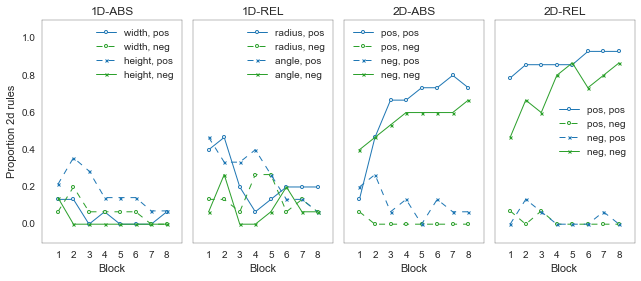

In [50]:
cc_styl = ['-o', '--']
cc_alpha = [1., 1.]

col = [[tableau20[0], tableau20[4]], [tableau20[0], tableau20[4]]]
styl = [['-o', '--o'], ['--x', '-x']]



fig, ax = plt.subplots(1, 4, figsize=(9,4), sharey=True)

for i, cond in enumerate([1, 0, 3, 2]):
    axi = ax[i]
    #for cc in [0, 1]:
    #    axi.plot(range(1, 9), p2d_pos[(cond, cc)], cc_styl[cc], label=(dim_label(cond, cc) + ', pos'), 
    #             color=cc_col[cc], alpha=cc_alpha[cc], linewidth=1.3)
    #    axi.plot(range(1, 9), p2d_neg[(cond, cc)], cc_styl[cc], label=(dim_label(cond, cc) + ', neg'), 
    #             color=cc_col[cc], alpha=cc_alpha[cc], linewidth=1.3)

    for cc in [0, 1]:
        axi.plot(range(1, 9), p2d_pos[(cond, cc)], styl[cc][0], label=(dim_label(cond, cc) + ', pos'), 
                 color=col[cc][0], alpha=cc_alpha[cc], linewidth=1,
                 markersize=3, markerfacecolor='white', markeredgecolor=col[cc][0], markeredgewidth=1)
        axi.plot(range(1, 9), p2d_neg[(cond, cc)], styl[cc][1], label=(dim_label(cond, cc) + ', neg'), 
                 color=col[cc][1], alpha=cc_alpha[cc], linewidth=1,
                markersize=3, markerfacecolor='white', markeredgecolor=col[cc][1], markeredgewidth=1)



    #axi.set_title(COND_LABELS[cond])
    axi.set_ylim(-.1, 1.1)
    axi.set_xlim(0, 9)
    axi.legend(loc='best')
    axi.set_xticks(range(1, 9))
    axi.set_xlabel('Block')
    axi.set_title(COND_LABELS[cond])
    for i in axi.spines.itervalues():
        i.set_linewidth(0.3)


ax[0].set_ylabel('Proportion 2d rules')

plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'exp2_prop_2d_rules.pdf', bbox_inches='tight')

# Best fit boundaries based on selection (training) data

In [32]:
# save to csv
for sid in SUBJ:
    for block in range(8):
        arr = [[x[0], x[1], y] for x, y in zip(selections(sid, block), selection_feedback(sid, block))]
        tdf = pd.DataFrame(arr, columns=['x1', 'x2', 'resp'])
        tdf['resp'] = map(lambda r: 0. if r=='success' else 1., tdf['resp'].values)
        tdf.to_csv('%s/traindata/traindata_%s_%s.csv' % (DATADEST, sid, block))

In [33]:
# read back in fits
arr = []
for sid in SUBJ:
    for block in range(8):
        fitresult = pd.read_csv('%s/fit_boundaries/fit_training_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        arr.append([sid, condition(sid), rule_counter(sid), block, 
                    fitresult.loc['(Intercept)']['Estimate'],
                    fitresult.loc['x1']['Estimate'],
                    fitresult.loc['x2']['Estimate'],
                    fitresult.loc['x1']['Pr(>|z|)'],
                    fitresult.loc['x2']['Pr(>|z|)']])

fitdf = pd.DataFrame(arr, columns=['sid', 'cond', 'counter', 'block', 
                                   'c_int', 'c_x1', 'c_x2',
                                   'p_x1', 'p_x2'])
fitdf['intercept'] = -fitdf.c_int/fitdf.c_x2
fitdf['slope'] = -fitdf.c_x1/fitdf.c_x2
fitdf['2drule'] = 1 * ((np.abs(fitdf.slope) > .25) & (np.abs(fitdf.slope) < 4))

In [35]:
# load results for comparison to null model
arr = []
for sid in SUBJ:
    for block in range(8):
        comp_result = pd.read_csv('%s/fit_boundaries/fit_training_comp_%s_%s.csv' % (DATADEST, sid, block), index_col=0)
        try:
            arr.append([comp_result.loc[1,'x'], comp_result.loc[2,'x'], comp_result.loc[3,'x']])
        except:
            print sid
            print comp_result
arr = np.array(arr)

fitdf['aic'] = arr[:,0]
fitdf['aic_x1'] = arr[:,1]
fitdf['aic_x2'] = arr[:,2]
fitdf['2drule_aic'] = 1*(fitdf['aic'] < fitdf['aic_x1']) & (fitdf['aic'] < fitdf['aic_x2'])

In [37]:
p2d_train = {}
for cond in range(4):
    for cc in [0, 1]:
        p2d_train[(cond, cc)] = [fitdf[(fitdf.cond==cond) & (fitdf.block==block) & (fitdf.counter%2==cc)]['2drule_aic'].mean() \
                           for block in range(8)]

In [38]:
print 'Proportion 2D rules based on training selections'
for cond in range(4):
    print COND_LABELS[cond], np.mean([p2d_train[(cond,0)], p2d_train[(cond,1)]])

Proportion 2D rules based on training selections
1D-REL 0.0416666666667
1D-ABS 0.0658482142857
2D-REL 0.748325892857
2D-ABS 0.754166666667
